In [13]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [14]:
import torch
from UnarySim.sw.kernel.linear import UnaryLinear
from UnarySim.sw.bitstream.gen import RNG, SourceGen, BSGen
from UnarySim.sw.metric.metric import ProgressiveError
import matplotlib.pyplot as plt


In [27]:
# rng = "Sobol"
rng = "Race"

in_feature = 128
out_feature = 10000

mode = "bipolar"
scaled = True
bias =   False

fc = torch.nn.Linear(in_feature, out_feature, bias=bias)

if mode is "unipolar":
    fc.weight.data = torch.rand(out_feature, in_feature).mul(256).round().div(256)
    if bias is True:
        fc.bias.data = torch.rand(1, out_feature).mul(256).round().div(256)
elif mode is "bipolar":
    fc.weight.data = torch.rand(out_feature, in_feature).mul(2).sub(1).mul(256).round().div(256)
    if bias is True:
        fc.bias.data = torch.rand(1, out_feature).mul(2).sub(1).mul(256).round().div(256)

ufc = UnaryLinear(in_feature, out_feature, fc.weight, fc.bias, mode=mode, scaled=scaled, bias=bias)

iVec = (torch.rand(1, in_feature)*256).round()/256
oVec = fc(iVec)

if scaled is False:
    oVec = oVec.clamp(-1.,1.).mul(256).floor()/256
else:
    if bias is True:
        oVec = oVec.div(in_feature+1).mul(256).floor()/256
    else:
        oVec = oVec.div(in_feature).mul(256).floor()/256


In [28]:
iVecSource = SourceGen(iVec, bitwidth=8, mode=mode)()

iVecRNG = RNG(8, 1, rng)()
iVecBS = BSGen(iVecSource, iVecRNG)

iVecPE = ProgressiveError(iVec, mode=mode)
oVecPE = ProgressiveError(oVec, mode=mode)

with torch.no_grad():
    idx = torch.zeros(iVecSource.size()).type(torch.long)
    for i in range(256):
#         print(i)
        iBS = iVecBS(idx + i)
        iVecPE.Monitor(iBS)
        
        oVecU = ufc(iBS)
        oVecPE.Monitor(oVecU)
#         print("\n")
    print("input error: ", min(min(iVecPE()[1])), max(max(iVecPE()[1])))
    print("output error:", min(min(oVecPE()[1])), max(max(oVecPE()[1])))
    print("output pp:", oVecPE()[0].data)
    result_pe = oVecPE()[1][0].numpy()
    print(torch.sqrt(torch.sum(torch.mul(oVecPE()[1], oVecPE()[1]))/out_feature))
    print(result_pe)

input error:  tensor(-0.0039) tensor(0.0039)
output error: tensor(-0.0078) tensor(0.)
output pp: tensor([[-0.0078, -0.0312, -0.0078,  ...,  0.0156,  0.0078, -0.0391]])
tensor(0.0049)
[-0.00390625 -0.00390625  0.         ... -0.0078125  -0.0078125
 -0.00390625]


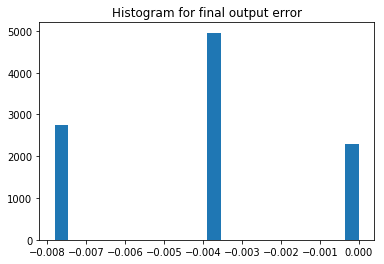

In [29]:
fig = plt.hist(result_pe, bins='auto')  # arguments are passed to np.histogram
plt.title("Histogram for final output error")
plt.show()

In [217]:
# passed test
# 1. unipolar,     scaled,     biased: passed
# 2. unipolar,     scaled, non-biased: passed
# 3. unipolar, non-scaled,     biased: passed
# 4. unipolar, non-scaled, non-biased: passed
# 5.  bipolar,     scaled,     biased: passed
# 6.  bipolar,     scaled, non-biased: passed
# 7.  bipolar, non-scaled,     biased: passed
# 8.  bipolar, non-scaled, non-biased: passed